In [1]:
from pyexpat import features
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.set_option('display.width',None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('future.no_silent_downcasting', True)

In [5]:
data = pd.read_excel('/content/drive/MyDrive/Datasets/PE-Data Mining Shoe Dataset.xlsx', index_col=False)
print("\n\n\nSample dataset :- \n\n")
data.head()




Sample dataset :- 




,RECEIPT_DATE,ITEM,BARCODE,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,EAN,LETHR_TYPE,SEASON,INDICATOR,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
0,2015-08-06,57390,7.133049e+12,7133-515,BLACK,38,TIPTOPP,FOOTWEAR,8903930389998,PU CFB,S14,B,1,499,0.0,0.0,499.0
1,2015-08-06,62848,5.555929e+12,9736,GREEN,36,GLIDERS,FOOTWEAR,8903930424569,EVA,W14,D,1,499,0.0,0.0,499.0
2,2015-08-06,71405,9.952018e+12,ADVENT-1,OLGREEN,5,FOOTFUN,FOOTWEAR,8903930676890,PU CFB,S15,A,1,599,0.0,0.0,599.0
3,2015-08-06,65259,5.555902e+12,LY-10420,PINK,38,FORCE 10,FOOTWEAR,8903930408866,PU CFB,S14,D,1,1599,0.0,0.0,1599.0
4,2015-08-06,55228,2.212005e+12,RS-016,D.GREY,8,FORCE 10,FOOTWEAR,8903930335025,PU CFB,W13,B,1,1299,0.0,0.0,1299.0


## **Starting EDA and Data Cleaning**

In [7]:
print("Shape of the dataset = ", end="")
print( data.shape)

Shape of the dataset = (37762, 17)


In [8]:
print("Sample data decription : \n")
print( data.describe() )

Sample data decription : 

                        RECEIPT_DATE           ITEM       BARCODE           QTY  GROSS_VALUE          DIS%    DISC_VALUE     NET_VALUE
count                          37762   37762.000000  3.760200e+04  37762.000000  37762.00000  37762.000000  37762.000000  37762.000000
mean   2018-03-25 17:10:51.893437696   49782.497670  5.540830e+12      1.031831    833.08686      5.984071     65.303467    767.783393
min              2015-08-06 00:00:00      78.000000  2.201800e+04     -3.000000  -6597.00000    -29.900000   -494.850000  -6597.000000
25%              2017-04-23 00:00:00   34234.750000  2.193009e+12      1.000000    349.00000      0.000000      0.000000    320.000000
50%              2018-04-22 00:00:00   51988.000000  5.555087e+12      1.000000    499.00000      0.000000      0.000000    499.000000
75%              2019-03-26 00:00:00   66291.000000  8.017056e+12      1.000000    999.00000      0.000000      0.000000    999.000000
max              2020-03-17 

###According to project requirement we don't need Barcode and EAN column as it is of no help to us, item no. acts as primary key

In [9]:
data.drop('BARCODE', axis = 1, inplace = True)
data.drop('EAN', axis = 1, inplace = True)

### Finding out NULL values

In [10]:
data.isnull().sum()

,0
RECEIPT_DATE,0
ITEM,0
ARTICLE_NAME,0
Colour,185
SIZE,2988
BRAND,51
P_GROUP,39
LETHR_TYPE,3020
SEASON,5688
INDICATOR,2322


###Observing Color column

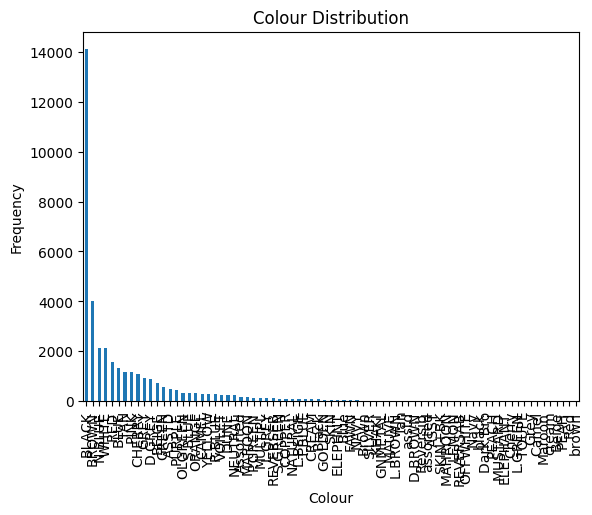

In [11]:
data['Colour'].value_counts().plot(kind='bar')
plt.title('Colour Distribution')
plt.xlabel('Colour')
plt.ylabel('Frequency')
plt.show()

### For colour column we can use mode value to fill null positions  as it is skewed way too much

In [12]:
data['Colour'] = data['Colour'].fillna(data['Colour'].mode()[0])

### Observing Size columns

In [13]:
data['SIZE'].unique()

array([38, 36, 5, 8, '08C', 41, 40, 3, 6, 42, 10, 9, 32, '13C', '12C', 29,
       33, '7C', 7, 2, 39, 43, '11C', 37, 4, 1, 31, 45, '07C', 30, 44, 11,
       '10C', '8C', '9C', 25, 24, nan, '05C', '09C', '06C', 35, 26, 27,
       28, 23, 46, '04C', 34, 22, '6C', '5C', 12, '3C', '(08', '4C',
       '(07'], dtype=object)

In [14]:
data["SIZE"] = data["SIZE"].astype(str).str.strip().str.upper()  # Removing spaces & normalize case

### Cleaning incorrect formats like '(08'

In [15]:
data['SIZE'] = [str(size).strip("()") if isinstance(size, str) else size for size in data['SIZE']]

### Creating a mapping
### Shoe size to cm mapping based on US, UK, and EU sizes

In [16]:
size_to_cm = {
     "38": 24.0, "36": 23.0, "5": 22.5, "8": 26.0, "08C": 15.0, "41": 26.5,
     "40": 25.5, "3": 21.5, "6": 23.5, "42": 27.0, "10": 28.0, "9": 27.5,
     "32": 20.0, "13C": 19.0, "12C": 18.5, "29": 17.0, "33": 20.5,
     "7C": 14.0, "7": 24.5, "2": 21.0, "39": 25.0, "43": 27.5,
     "11C": 17.5, "37": 23.5, "4": 22.0, "1": 20.5, "31": 19.5,
     "45": 29.0, "07C": 13.5, "30": 18.0, "44": 28.0, "11": 29.0,
     "10C": 16.5, "8C": 14.5, "9C": 15.5, "25": 15.0, "24": 14.5,
     "05C": 12.0, "09C": 15.0, "06C": 13.0, "35": 22.5, "26": 16.0,
     "27": 16.5, "28": 17.0, "23": 14.0, "46": 29.5, "04C": 11.5,
     "34": 21.0, "22": 13.5, "6C": 13.5, "5C": 12.5, "12": 30.0,
     "3C": 11.0, "4C": 11.5, "08" : 26.0, "07" : 24.5
 }

### Mapping sizes to centimeters and fill missing values with "Unknown"

In [18]:
data["SIZE"] = data["SIZE"].map(size_to_cm).fillna("Unknown")

In [19]:
#Verifying
data['SIZE'].unique()

array([24.0, 23.0, 22.5, 26.0, 15.0, 26.5, 25.5, 21.5, 23.5, 27.0, 28.0,
       27.5, 20.0, 19.0, 18.5, 17.0, 20.5, 14.0, 24.5, 21.0, 25.0, 17.5,
       22.0, 19.5, 29.0, 13.5, 18.0, 16.5, 14.5, 15.5, 'Unknown', 12.0,
       13.0, 16.0, 29.5, 11.5, 12.5, 30.0, 11.0], dtype=object)

### Mapping has been created and implemented to the data frame. Now we will handle null values.
### I have changed all NAN values to Unknown
### We will fill NAN values with mode(Categorical)

In [20]:
mode_value = data["SIZE"].mode()[0]
data["SIZE"] = data["SIZE"].replace("Unknown", mode_value)

In [21]:
#Verifying
data['SIZE'].unique()

array([24.0, 23.0, 22.5, 26.0, 15.0, 26.5, 25.5, 21.5, 23.5, 27.0, 28.0,
       27.5, 20.0, 19.0, 18.5, 17.0, 20.5, 14.0, 24.5, 21.0, 25.0, 17.5,
       22.0, 19.5, 29.0, 13.5, 18.0, 16.5, 14.5, 15.5, 12.0, 13.0, 16.0,
       29.5, 11.5, 12.5, 30.0, 11.0], dtype=object)

In [22]:
data.isnull().sum()

,0
RECEIPT_DATE,0
ITEM,0
ARTICLE_NAME,0
Colour,0
SIZE,0
BRAND,51
P_GROUP,39
LETHR_TYPE,3020
SEASON,5688
INDICATOR,2322


### Observing P_GROUP column

In [23]:
data['P_GROUP'].unique()

array(['FOOTWEAR', 'ACCESSORIES', nan], dtype=object)


### I observed that P_Group has two categories hence null values will have to be handled accordingly. If we randomly put mode/mean, there will be some footwear which might obtain brands of accessories.

### Printing the accessory brands

In [25]:
data[data['P_GROUP'] == 'ACCESSORIES']['BRAND'].unique()

array(['LFO', 'LSL', 'ACCESSORIES', nan], dtype=object)

### If the Brand is LFO or LSL we know its a ACCESSORIES

In [26]:
data.loc[data['P_GROUP'].isnull() & data['BRAND'].isin(['LFO', 'LSL']), 'P_GROUP'] = 'ACCESSORIES'

### If the BRAND is different from LFO or LSL we know its a footwear

In [27]:
data.loc[data['P_GROUP'].isnull() & ~data['BRAND'].isin(['LFO', 'LSL']), 'P_GROUP'] = 'FOOTWEAR'

In [28]:
data.isnull().sum()

,0
RECEIPT_DATE,0
ITEM,0
ARTICLE_NAME,0
Colour,0
SIZE,0
BRAND,51
P_GROUP,0
LETHR_TYPE,3020
SEASON,5688
INDICATOR,2322


### Observing Brand column

In [29]:
data['BRAND'].unique()

array(['TIPTOPP', 'GLIDERS', 'FOOTFUN', 'FORCE 10', 'SENORITA', 'PREFECT',
       'COOLERS', 'WINDSOR', 'FORTUNE', 'WARRIOR', 'LFO',
       'CUSTOMER BRAND', nan, 'A-HA', 'LSL', 'LUCY & LUKE', 'ACCESSORIES',
       'REBOUNCE', 'HEALERS', 'LEAP7X'], dtype=object)

### Using the same logic if the BRAND is None, and if we know that P_GROUP is ACCESSORY then we know that it is either LFO or LSL(we take the mode)

In [30]:
data.loc[data['BRAND'].isnull() & data['P_GROUP'].isin(['ACCESSORIES']), 'BRAND'] = 'LFO'

### And if the P_GROUP is footwear we know that is the companies other than LFO OR LSL(we take the mode between those all companies)

In [31]:
data.loc[data['BRAND'].isnull() & data['P_GROUP'].isin(['FOOTWEAR']), 'BRAND'] = 'GLIDERS'

### Observing Leather_Type column

In [32]:
data[data['LETHR_TYPE'].isnull()].head()

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,INDICATOR,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
490,2015-09-28,44970,MB72502,BLACK,23.5,LFO,ACCESSORIES,NaN,NaN,D,1,110,0.0,0.0,110.0
579,2015-10-08,44970,MB72502,BLACK,23.5,LFO,ACCESSORIES,NaN,NaN,D,1,110,0.0,0.0,110.0
841,2015-11-01,57633,HC-201,NATURAL,23.5,LFO,ACCESSORIES,NaN,NaN,NaN,1,299,0.0,0.0,299.0
1028,2015-11-10,76346,AL-195,BLACK,23.5,LFO,ACCESSORIES,NaN,NaN,NaN,1,1299,0.0,0.0,1299.0
1039,2015-11-10,57633,HC-201,NATURAL,23.5,LFO,ACCESSORIES,NaN,NaN,NaN,1,299,10.0,29.9,269.1


### Filling the nan values of lethr type wherever p_group is accessories as not applicable as any accessory inherently wont have a leather type.

In [33]:
data.loc[data["P_GROUP"] == "ACCESSORIES", "LETHR_TYPE"] = "Not Applicable"

In [34]:
data[data['LETHR_TYPE'].isnull()].head()

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,INDICATOR,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
2202,2016-01-19,78471,LB-014,GOLDEN,21.5,GLIDERS,FOOTWEAR,NaN,W15,A,1,249,0.0,0.0,249.0
2379,2016-01-29,78473,LB-014,GOLDEN,22.5,GLIDERS,FOOTWEAR,NaN,W15,A,1,249,0.0,0.0,249.0
2521,2016-02-04,78472,LB-014,GOLDEN,22.0,GLIDERS,FOOTWEAR,NaN,W15,A,1,249,0.0,0.0,249.0
2595,2016-02-08,79172,LBT-062,PINK,25.0,GLIDERS,FOOTWEAR,NaN,NaN,A,1,399,0.0,0.0,399.0
2654,2016-02-11,79104,LIM-F802N,RED,24.0,GLIDERS,FOOTWEAR,NaN,NaN,A,1,1199,0.0,0.0,1199.0


### For the rest of the values as this is categorical data we use mode

In [35]:
data['LETHR_TYPE'] = data['LETHR_TYPE'].fillna(data['LETHR_TYPE'].mode()[0])

In [36]:
data.isnull().sum()

,0
RECEIPT_DATE,0
ITEM,0
ARTICLE_NAME,0
Colour,0
SIZE,0
BRAND,0
P_GROUP,0
LETHR_TYPE,0
SEASON,5688
INDICATOR,2322


### Observing Seasons column

In [37]:
data.loc[data['SEASON'].isnull()].head()

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,INDICATOR,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
490,2015-09-28,44970,MB72502,BLACK,23.5,LFO,ACCESSORIES,Not Applicable,NaN,D,1,110,0.0,0.0,110.0
507,2015-10-01,74371,7168-03,BLACK,26.0,FORTUNE,FOOTWEAR,PATINA,NaN,B,1,1999,10.0,199.9,1799.1
579,2015-10-08,44970,MB72502,BLACK,23.5,LFO,ACCESSORIES,Not Applicable,NaN,D,1,110,0.0,0.0,110.0
658,2015-10-16,75583,9906-10,ELEPHNT,27.5,FORCE 10,FOOTWEAR,NUBUCK,NaN,B,1,1799,0.0,0.0,1799.0
659,2015-10-16,75771,9906-10,WHITE,27.5,FORCE 10,FOOTWEAR,SOFTY,NaN,B,1,1799,0.0,0.0,1799.0


In [38]:
data['SEASON'].unique()

array(['S14', 'W14', 'S15', 'W13', 'S11', 'UNIVRSL', 'WINTER', 'W11',
       'SUMMER', 'S13', 'S12', 'W12', 'W15', nan, 'S16', 'W16', 'S17',
       'W17', 'S18', 'SS', 'AW', 'W10', 'S10', 'W18', 'S19', 'W19', 'S20'],
      dtype=object)

In [39]:
data.loc[data['SEASON'] == 'S11'].head()

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,INDICATOR,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
6,2015-08-06,37245,SHREEK-05,RED,15.0,FORCE 10,FOOTWEAR,PU CFB,S11,D,1,599,0.0,0.0,599.0
402,2015-09-20,27353,JONIX,OLGREEN,24.5,COOLERS,FOOTWEAR,PU CFB,S11,B,1,599,0.0,0.0,599.0
710,2015-10-20,28593,KIZASHI,S.BLUE,25.5,TIPTOPP,FOOTWEAR,PU CFB,S11,A,1,299,0.0,0.0,299.0
748,2015-10-24,56307,7123-130,BLACK,27.5,COOLERS,FOOTWEAR,PU CFB,S11,B,1,899,0.0,0.0,899.0
1117,2015-11-14,17133,BERLIN,BROWN,24.0,TIPTOPP,FOOTWEAR,PVC CFB,S11,B,1,349,0.0,0.0,349.0


### Checking which have most missing values in season, accessories or footwear


In [40]:
data.groupby("P_GROUP")["SEASON"].apply(lambda x: x.isnull().sum())

,SEASON
P_GROUP,
ACCESSORIES,2972
FOOTWEAR,2716


### Both are equal in null values

### Checking article name that have null season

In [41]:
data[data["SEASON"].isnull()]["ARTICLE_NAME"].value_counts()

,count
ARTICLE_NAME,
TRENDY,598
WP-60,261
S/BOY EXCE,162
S/BOY-V,162
ESH-01,148
LB-16,130
3070-27,116
SBK,113
DR-519,106


In [45]:
data.loc[data['ARTICLE_NAME'] == "TRENDY"]

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,INDICATOR,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
74,2015-08-15,43847,TRENDY,WHITE,22.0,GLIDERS,FOOTWEAR,EVA,UNIVRSL,D,1,175,0.000000,0.0,175.0
167,2015-08-23,58997,TRENDY,BLACK,22.0,GLIDERS,FOOTWEAR,EVA,SUMMER,B,1,199,0.000000,0.0,199.0
168,2015-08-23,58999,TRENDY,D.GREY,22.0,GLIDERS,FOOTWEAR,EVA,SUMMER,B,1,199,0.000000,0.0,199.0
169,2015-08-23,59040,TRENDY,D.GREY,22.5,GLIDERS,FOOTWEAR,EVA,SUMMER,B,1,199,0.000000,0.0,199.0
196,2015-08-28,59279,TRENDY,N.BLUE,24.5,GLIDERS,FOOTWEAR,EVA,SUMMER,B,0,0,0.000000,0.0,0.0
221,2015-08-30,58997,TRENDY,BLACK,22.0,GLIDERS,FOOTWEAR,EVA,SUMMER,B,1,199,0.000000,0.0,199.0
222,2015-08-30,59170,TRENDY,N.BLUE,22.0,GLIDERS,FOOTWEAR,EVA,SUMMER,B,1,199,0.000000,0.0,199.0
307,2015-09-08,58997,TRENDY,BLACK,22.0,GLIDERS,FOOTWEAR,EVA,SUMMER,B,1,199,0.000000,0.0,199.0
319,2015-09-09,59170,TRENDY,N.BLUE,22.0,GLIDERS,FOOTWEAR,EVA,SUMMER,B,1,199,0.000000,0.0,199.0
331,2015-09-10,40135,TRENDY,WHITE,22.5,GLIDERS,FOOTWEAR,EVA,UNIVRSL,D,1,175,0.000000,0.0,175.0


### Filter data where ARTICLE_NAME is "TRENDY"
### Categorical analysis of seasons for article name == trendy

In [43]:
trendy_data = data[data["ARTICLE_NAME"] == "TRENDY"]

### Counting occurrences of each SEASON category

In [44]:
season_counts = trendy_data["SEASON"].value_counts()
season_counts

,count
SEASON,
SUMMER,613
SS,249
UNIVRSL,55


In [46]:
data.loc[(data["ARTICLE_NAME"] == "TRENDY") & (data["SEASON"].isnull()), "SEASON"] = "SUMMER"

In [47]:
data.loc[( data["ARTICLE_NAME"] == "LB-16") ].head(20)

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,INDICATOR,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
19212,2018-05-05,51936,LB-16,MULTIPL,22.0,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0
19240,2018-05-06,51937,LB-16,MULTIPL,22.5,GLIDERS,FOOTWEAR,EVA,NaN,E,2,350,0.000000,0.0,350.0
19315,2018-05-10,51938,LB-16,MULTIPL,23.5,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0
19387,2018-05-13,51936,LB-16,MULTIPL,22.0,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0
19388,2018-05-13,51937,LB-16,MULTIPL,22.5,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0
19489,2018-05-19,51937,LB-16,MULTIPL,22.5,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0
19614,2018-05-26,51936,LB-16,MULTIPL,22.0,GLIDERS,FOOTWEAR,EVA,NaN,E,3,525,0.000000,0.0,525.0
19704,2018-06-02,51938,LB-16,MULTIPL,23.5,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0
19817,2018-06-09,51937,LB-16,MULTIPL,22.5,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0
19844,2018-06-10,51938,LB-16,MULTIPL,23.5,GLIDERS,FOOTWEAR,EVA,NaN,E,1,175,0.000000,0.0,175.0


In [48]:
data.loc[ (data["ARTICLE_NAME"] == "LB-16") & (data["SEASON"].isnull()), "SEASON"] = "UNIVRSL"

In [49]:
# VERIFY
data[data["ARTICLE_NAME"] == "LB-16"]["SEASON"].isnull().sum() # Should print 0

0

In [50]:
data[data["SEASON"].isnull()]["ARTICLE_NAME"].value_counts()

,count
ARTICLE_NAME,
WP-60,261
S/BOY-V,162
S/BOY EXCE,162
ESH-01,148
3070-27,116
SBK,113
DR-519,106
SC-03,86
DR-526,82


### Automating this process using loops

In [51]:
# This returns the mode value
def safe_mode(x):
    mode = x.mode()
    if not mode.empty:
        return mode.iloc[0]  # Return the first mode if multiple modes exist
    return 'UNIVRSL'  #Return 'UNIVERSAL' if no mode exists (i.e., all values are unique or NaN)

In [52]:
# Replace NaN values in SEASON with the mode for each ARTICLE_NAME
def fill_season_mode(data):

    mode_seasons = data.groupby('ARTICLE_NAME')['SEASON'].agg(safe_mode).reset_index()


    data = data.merge(mode_seasons, on='ARTICLE_NAME', how='left', suffixes=('', '_mode'))

    # Fill NaN values in SEASON with the corresponding mode from the merged column
    data['SEASON'] = data['SEASON'].fillna(data['SEASON_mode'])


    data.drop(columns=['SEASON_mode'], inplace=True)

    return data

data = fill_season_mode(data)

# Verify
data[data['SEASON'].isnull()]["ARTICLE_NAME"].value_counts()

,count
ARTICLE_NAME,


In [53]:
data.isnull().sum()

,0
RECEIPT_DATE,0
ITEM,0
ARTICLE_NAME,0
Colour,0
SIZE,0
BRAND,0
P_GROUP,0
LETHR_TYPE,0
SEASON,0
INDICATOR,2322


### We can simply drop indicator column as it is of no use to our problem statement

In [54]:
data = data.drop('INDICATOR', axis=1)

In [55]:
data.isnull().sum()

,0
RECEIPT_DATE,0
ITEM,0
ARTICLE_NAME,0
Colour,0
SIZE,0
BRAND,0
P_GROUP,0
LETHR_TYPE,0
SEASON,0
QTY,0


In [56]:
data['SEASON'] = data['SEASON'].replace({
    "S10": "SUMMER",
    "S11": "SUMMER",
    "S12": "SUMMER",
    "S13": "SUMMER",
    "S14": "SUMMER",
    "S15": "SUMMER",
    "S16": "SUMMER",
    "S17": "SUMMER",
    "S18": "SUMMER",
    "S19": "SUMMER",
    "S20": "SUMMER",
    "SS": "SUMMER",
    "W10": "WINTER",
    "W11": "WINTER",
    "W12": "WINTER",
    "W13": "WINTER",
    "W14": "WINTER",
    "W15": "WINTER",
    "W16": "WINTER",
    "W17": "WINTER",
    "W18": "WINTER",
    "W19": "WINTER",
    "W20": "WINTER",
    "AW": "WINTER",
})

In [57]:
data['SEASON'].unique()

array(['SUMMER', 'WINTER', 'UNIVRSL'], dtype=object)

### Observing GROSS_VALUE: Some values are negative.

In [58]:
data["GROSS_VALUE"].unique()

array([  499,   599,  1599,  1299,  1598,   399,  1399,   899,   349,
         999,   299,   699,  1999,  1699,   750,  1499,   799,     0,
        1199,   275,  1799,   175,   350,  2699,   325,  -275,  1099,
         449,  2199,   749,   199,   375,  -499,  -699,   998,  2999,
         550,  1998,   598,   425,   225,   698,  3499,  -349,   110,
         398,  2299,  -299,  2599,  -399, -1299,  -799,  2499,   798,
        -199,  -899, -1398,  -999,  -175,  2398,  1398,  2198,  2798,
         249, -2199,  1899,   850,  -225,    99,   251,  -250,   100,
         250,   597,  3598, -6597,  2799,  3299,   240,  5398,  -325,
       -1099, -1599,  1500, -1699,  -599,   498, -1999,   650,  -750,
        1798,  1047,  1198,  2250,  2997,  1797,  1347, -1499,  7996,
       -1799,   897,   700,   898, -3499,  -251,  3996, -1899,   975,
        -698,  4998,  3398, -1399, -2999,   649,   450,  5998,  2998,
        1100,  1495,  -550,  1197,  3000,  4398,  -425,   220,   320,
         130, -1198,

In [59]:
data["GROSS_VALUE"] = data["GROSS_VALUE"].apply(lambda x: abs(x) if str(x).startswith('-') else x)

In [60]:
data["GROSS_VALUE"].unique()

array([ 499,  599, 1599, 1299, 1598,  399, 1399,  899,  349,  999,  299,
        699, 1999, 1699,  750, 1499,  799,    0, 1199,  275, 1799,  175,
        350, 2699,  325, 1099,  449, 2199,  749,  199,  375,  998, 2999,
        550, 1998,  598,  425,  225,  698, 3499,  110,  398, 2299, 2599,
       2499,  798, 1398, 2398, 2198, 2798,  249, 1899,  850,   99,  251,
        250,  100,  597, 3598, 6597, 2799, 3299,  240, 5398, 1500,  498,
        650, 1798, 1047, 1198, 2250, 2997, 1797, 1347, 7996,  897,  700,
        898, 3996,  975, 4998, 3398,  649,  450, 5998, 2998, 1100, 1495,
       1197, 3000, 4398,  220,  320,  130,    5,  502,    9,    7,   10,
        200,   22,   75,    3,    4,    6,    1,  525,  796, 3198, 2399,
       2598, 3998,    2,   90,  180,   50,  500,   20, 1000,   80,   25,
        198,   70,  300,  150,   14,   60,   12,   30,  270,   13,  400,
         17,   19,  950,    8,   18,  120,  396,  160,   65,   11,   16,
        129,  360,  149,  210, 1497,  995,  675, 11

### Checking where gross value is zero

In [61]:
data['P_GROUP'].loc[data['GROSS_VALUE'] == 0]
indexZeroPrice = data[ (data['GROSS_VALUE'] == 0) ].index
data.drop(indexZeroPrice , inplace=True)
data.head(15)
#Verifying
data['P_GROUP'].loc[data['GROSS_VALUE'] == 0]

,P_GROUP


### There are many items where quantity is negative

In [65]:
data.loc[data['QTY'] <= 0].size

5894

In [67]:
indexZeroQTY = data[ (data['QTY'] <= 0) ].index
data.drop(indexZeroQTY , inplace=True)
data.head(15)
#Verifying
data.loc[data['QTY'] <= 0].size

0

In [68]:
data.loc[data['DIS%'] < 0]
indexZeroDisc = data[ (data['DIS%'] < 0)].index
data.drop(indexZeroDisc , inplace=True)

### There are rows where discount is 100


In [70]:
data.loc[data['DIS%'] == 100].head(10)

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
2292,2016-01-25,61959,LIC-406,RED,26.0,GLIDERS,FOOTWEAR,PU CFB,WINTER,1,999,100.0,999.0,0.0
5410,2016-09-10,73869,2046-248,BLACK,25.5,WINDSOR,FOOTWEAR,VENUS,WINTER,1,2499,100.0,2499.0,0.0
5411,2016-09-10,73870,2046-248,BLACK,26.5,WINDSOR,FOOTWEAR,VENUS,WINTER,2,4998,100.0,4998.0,0.0
5413,2016-09-10,73873,2046-248,BLACK,28.0,WINDSOR,FOOTWEAR,VENUS,WINTER,1,2499,100.0,2499.0,0.0
6211,2016-11-15,84107,LP-1254,RED,24.0,SENORITA,FOOTWEAR,PU CFB,WINTER,1,999,100.0,999.0,0.0
6261,2016-11-19,31137,NICO,N.BLUE,24.5,GLIDERS,FOOTWEAR,PVC CFB,WINTER,1,350,100.0,350.0,0.0
7976,2017-02-13,2746,8204,BLACK,23.5,FORTUNE,FOOTWEAR,NAPPA,WINTER,1,2999,100.0,2999.0,0.0
8766,2017-03-29,67973,GI-F-011,BLUE,28.0,FORCE 10,FOOTWEAR,PU CFB,WINTER,1,2199,100.0,2199.0,0.0
9326,2017-04-18,33478,POKAR,BROWN,23.5,COOLERS,FOOTWEAR,PVC CFB,SUMMER,1,349,100.0,349.0,0.0
9864,2017-05-25,75442,DR-526,BLACK,25.5,TIPTOPP,FOOTWEAR,SOFTY,SUMMER,1,1599,100.0,1599.0,0.0


In [72]:
indexFullDisc = data[ (data['DIS%'] == 100)].index
data.drop(indexFullDisc , inplace=True)
#Verifying
data.loc[data['DIS%'] == 100].size


0

### There are values where net_value is 0

In [73]:
data.loc[data['NET_VALUE'] == 0]
indexZeroPrice = data[ (data['NET_VALUE'] == 0)].index
data.drop(indexZeroPrice , inplace=True)
#Verifying
data.loc[data['DIS%'] == 100]

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE


In [74]:
data[data["GROSS_VALUE"] == 0].shape[0]

0

In [75]:
data[data["GROSS_VALUE"] == 0]

,RECEIPT_DATE,ITEM,ARTICLE_NAME,Colour,SIZE,BRAND,P_GROUP,LETHR_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE


### Handling spelling errors and uniformity

In [76]:
data.rename(columns={"Colour": "COLOUR", "P_GROUP": "ITEM_TYPE", "LETHR_TYPE": "LEATHER_TYPE"}, inplace=True)

### Correcting the Date Format

In [77]:
data['RECEIPT_DATE'].head()

,RECEIPT_DATE
0,2015-08-06
1,2015-08-06
2,2015-08-06
3,2015-08-06
4,2015-08-06


In [78]:
data['RECEIPT_DATE'] = pd.to_datetime(data['RECEIPT_DATE'])
data['YEAR'] = data['RECEIPT_DATE'].dt.year
data['MONTH'] = data['RECEIPT_DATE'].dt.month
data['DATE'] = data['RECEIPT_DATE'].dt.day

In [79]:
last_col = data.columns[-1]
col_data = data.pop(last_col)
data.insert(0, last_col, col_data)

last_col = data.columns[-1]
col_data = data.pop(last_col)
data.insert(0, last_col, col_data)

last_col = data.columns[-1]
col_data = data.pop(last_col)
data.insert(0, last_col, col_data)

In [80]:
### Deleting the old date format column

In [81]:
data.drop(columns=["RECEIPT_DATE"], inplace=True)

In [82]:
data.head()

,YEAR,MONTH,DATE,ITEM,ARTICLE_NAME,COLOUR,SIZE,BRAND,ITEM_TYPE,LEATHER_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
0,2015,8,6,57390,7133-515,BLACK,24.0,TIPTOPP,FOOTWEAR,PU CFB,SUMMER,1,499,0.0,0.0,499.0
1,2015,8,6,62848,9736,GREEN,23.0,GLIDERS,FOOTWEAR,EVA,WINTER,1,499,0.0,0.0,499.0
2,2015,8,6,71405,ADVENT-1,OLGREEN,22.5,FOOTFUN,FOOTWEAR,PU CFB,SUMMER,1,599,0.0,0.0,599.0
3,2015,8,6,65259,LY-10420,PINK,24.0,FORCE 10,FOOTWEAR,PU CFB,SUMMER,1,1599,0.0,0.0,1599.0
4,2015,8,6,55228,RS-016,D.GREY,26.0,FORCE 10,FOOTWEAR,PU CFB,WINTER,1,1299,0.0,0.0,1299.0


In [83]:
data["COLOUR"] = data["COLOUR"].replace({
    "OLGREEN" : "OLIVE_GREEN",
    "D.GREY" : "DARK_GREY",
    "R.BLUE": "RED BLUE",
    "P.GREEN": "PALE GREEN",
    "T.BLUE": "TURQUOISE BLUE",
    "N.BLUE": "NAVY BLUE",
    "L.BEIGE": "LIGHT BEIGE",
    "Maroon": "MAROON",
    "MAHROON": "MAROON",
    "purple": "PURPLE",
    "violet": "VIOLET",
    "S.BLUE": "SKY BLUE",
    "elephnt": "ELEPHANT",
    "ELEPHNT": "ELEPHANT",
    "S.GREEN": "SAGE GREEN",
    "natural": "NATURAL",
    "golden": "GOLDEN",
    "cream": "CREAM",
    "D.BROWN": "DARK BROWN",
    "L.GREY": "LIGHT GREY",
    "Black": "BLACK",
    "black": "BLACK",
    "ASSTD": "ASSORTED",
    "ASST": "ASSORTED",
    "asstd": "ASSORTED",
    "assorted": "ASSORTED",
    "OFFWHITE": "OFF WHITE",
    "GNMETAL": "GUN METAL",
    "REVERSAB": "REVERSIBLE",
    "REVERSEB" :  "REVERSIBLE",
    "Reversib" :  "REVERSIBLE",
    "Brown": "BROWN",
    "brown" : "BROWN",
    "lemon": "LEMON",
    "L.GREEN": "LIGHT GREEN",
    "fawn": "FAWN",
    "neutral": "NEUTRAL",
    "skin": "SKIN",
    "silver": "SILVER",
    "beige": "BEIGE",
    "Beige": "BEIGE",
    "multipl": "MULTI",
    "MULTIPL": "MULTI",
    "khaki": "KHAKI",
    "Blue": "BLUE",
    "Navy": "NAVY",
    "skin+bk": "SKIN BLACK",
    "Assorted": "ASSORTED",
    "Tan": "TAN",
    "L.BROWN": "LIGHT BROWN",
    "Camel": "CAMEL",
    "toupe": "TOUPE",
    "Cherry": "CHERRY",
    "Dark Bro": "DARK BROWN",
    "Grey": "GREY",
    "mauve": "MAUVE",
    "mustard": "MUSTARD",
    "peach": "PEACH",
    "PEAH": "PEACH",
    "Red": "RED",
})

In [84]:
data["COLOUR"].unique()

array(['BLACK', 'GREEN', 'OLIVE_GREEN', 'PINK', 'DARK_GREY', 'RED',
       'WHITE', 'BROWN', 'CHERRY', 'CAMEL', 'BLUE', 'DUNE', 'COPPER',
       'BEIGE', 'YELLOW', 'TAN', 'GREY', 'RED BLUE', 'PALE GREEN',
       'ORANGE', 'TURQUOISE BLUE', 'NAVY BLUE', 'LIGHT BEIGE', 'MAROON',
       'PURPLE', 'VOILET', 'ELEPHANT', 'SKY BLUE', 'SAGE GREEN',
       'NATURAL', 'GOLDEN', 'CREAM', 'DARK BROWN', 'LIGHT GREY',
       'ASSORTED', 'OFF WHITE', 'REVERSIBLE', 'GUN METAL', 'LEMON',
       'FAWN', 'NEUTRAL', 'SKIN', 'LIGHT GREEN', 'SILVER', 'MULTI',
       'KHAKI', 'NAVY', 'SKIN+BK', 'LIGHT BROWN', 'TOUPE', 'MAUVE',
       'MUSTARD', 'PEACH'], dtype=object)

In [85]:
data["SEASON"].unique()

array(['SUMMER', 'WINTER', 'UNIVRSL'], dtype=object)

In [87]:
data.loc[data['QTY'] == min(data['QTY'])].head(10)

,YEAR,MONTH,DATE,ITEM,ARTICLE_NAME,COLOUR,SIZE,BRAND,ITEM_TYPE,LEATHER_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
0,2015,8,6,57390,7133-515,BLACK,24.0,TIPTOPP,FOOTWEAR,PU CFB,SUMMER,1,499,0.0,0.0,499.0
1,2015,8,6,62848,9736,GREEN,23.0,GLIDERS,FOOTWEAR,EVA,WINTER,1,499,0.0,0.0,499.0
2,2015,8,6,71405,ADVENT-1,OLIVE_GREEN,22.5,FOOTFUN,FOOTWEAR,PU CFB,SUMMER,1,599,0.0,0.0,599.0
3,2015,8,6,65259,LY-10420,PINK,24.0,FORCE 10,FOOTWEAR,PU CFB,SUMMER,1,1599,0.0,0.0,1599.0
4,2015,8,6,55228,RS-016,DARK_GREY,26.0,FORCE 10,FOOTWEAR,PU CFB,WINTER,1,1299,0.0,0.0,1299.0
6,2015,8,6,37245,SHREEK-05,RED,15.0,FORCE 10,FOOTWEAR,PU CFB,SUMMER,1,599,0.0,0.0,599.0
7,2015,8,6,52497,TENNIS-E,WHITE,26.0,GLIDERS,FOOTWEAR,DRILL,UNIVRSL,1,399,0.0,0.0,399.0
8,2015,8,7,67507,32332-01 N,BROWN,26.5,SENORITA,FOOTWEAR,NUBUCK,WINTER,1,1399,0.0,0.0,1399.0
9,2015,8,7,47423,345-37,CHERRY,25.5,TIPTOPP,FOOTWEAR,PU CFB,WINTER,1,899,0.0,0.0,899.0
10,2015,8,7,62850,9736,GREEN,24.0,GLIDERS,FOOTWEAR,EVA,WINTER,1,499,0.0,0.0,499.0


### Differentiating between categorical and numerical columns to start scaling and encoding

In [88]:
data['BRAND'].unique()
data.shape

(36668, 16)

In [89]:
data.columns

Index(['YEAR', 'MONTH', 'DATE', 'ITEM', 'ARTICLE_NAME', 'COLOUR', 'SIZE', 'BRAND', 'ITEM_TYPE',
       'LEATHER_TYPE', 'SEASON', 'QTY', 'GROSS_VALUE', 'DIS%', 'DISC_VALUE', 'NET_VALUE'],
      dtype='object')

In [91]:
data['ITEM'].unique().size

11681

In [90]:
data.loc[data['ITEM'] == 57390]

,YEAR,MONTH,DATE,ITEM,ARTICLE_NAME,COLOUR,SIZE,BRAND,ITEM_TYPE,LEATHER_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
0,2015,8,6,57390,7133-515,BLACK,24.0,TIPTOPP,FOOTWEAR,PU CFB,SUMMER,1,499,0.0,0.0,499.0
554,2015,10,6,57390,7133-515,BLACK,24.0,TIPTOPP,FOOTWEAR,PU CFB,SUMMER,1,499,0.0,0.0,499.0
1568,2015,12,5,57390,7133-515,BLACK,24.0,TIPTOPP,FOOTWEAR,PU CFB,SUMMER,1,499,0.0,0.0,499.0


### Scaling and Encoding Features

### To apply ANN we need all categorical columns into numbers so we use encoding techniques

In [92]:
from sklearn.preprocessing import LabelEncoder
# For High-Cardinality Categorical Features → Label Encoding is used
categorical_cols = ['ARTICLE_NAME', 'ITEM', 'BRAND', 'COLOUR', 'LEATHER_TYPE']

for col in categorical_cols:
    data[col] = data[col].astype(str)  # Convert to string

# Now apply Label Encoding
from sklearn.preprocessing import LabelEncoder

label_encoders = {}

for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    data[col] = label_encoders[col].fit_transform(data[col])


ITEM_TYPE_MAPPING = {
    "FOOTWEAR" : 0,
    "ACCESSORIES" : 1,
}

data["ITEM_TYPE"] = data["ITEM_TYPE"].map(ITEM_TYPE_MAPPING)

data["SEASON"] = data["SEASON"].replace({"UNIVRSL" : "UNIVERSAL"})

SEASON_MAP ={
    "SUMMER": 0,
    "WINTER" : 1,
    "UNIVERSAL" : 2,
}

data["SEASON"] = data["SEASON"].map(SEASON_MAP)
data.head()

,YEAR,MONTH,DATE,ITEM,ARTICLE_NAME,COLOUR,SIZE,BRAND,ITEM_TYPE,LEATHER_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
0,2015,8,6,5873,126,2,24.0,16,0,19,0,1,499,0.0,0.0,499.0
1,2015,8,6,6978,162,15,23.0,7,0,9,1,1,499,0.0,0.0,499.0
2,2015,8,6,8203,218,33,22.5,4,0,19,0,1,599,0.0,0.0,599.0
3,2015,8,6,7386,1196,37,24.0,5,0,19,0,1,1599,0.0,0.0,1599.0
4,2015,8,6,5348,1451,10,26.0,5,0,19,1,1,1299,0.0,0.0,1299.0


### Scaling Numerical Features
### Before scaling we check if it is normally distributed or not


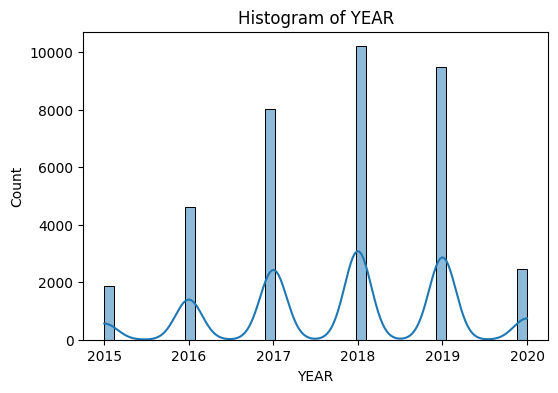

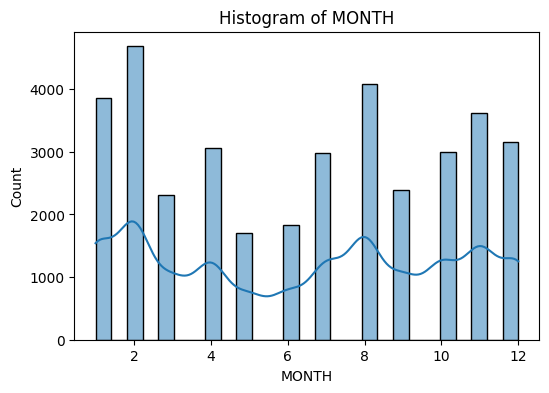

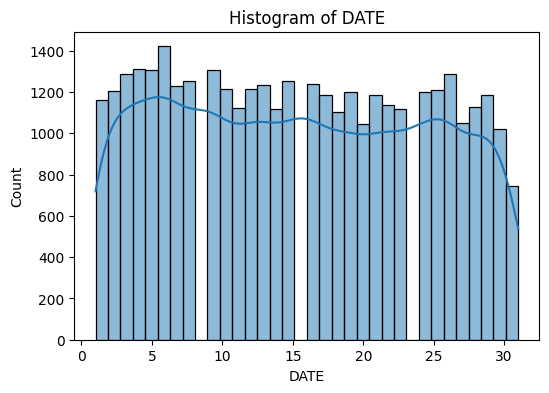

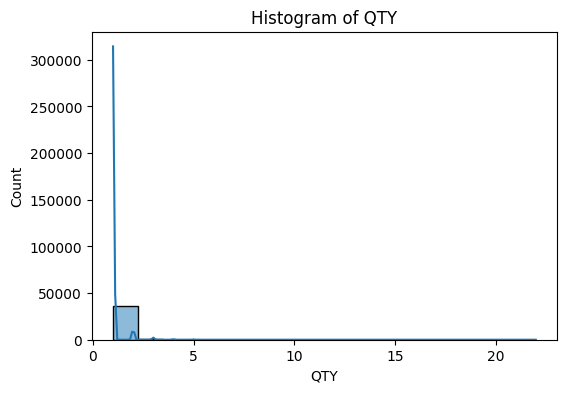

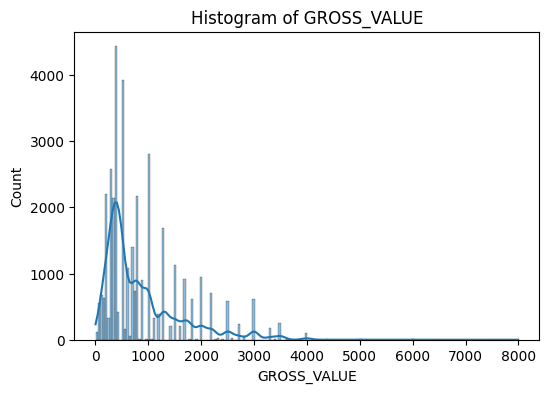

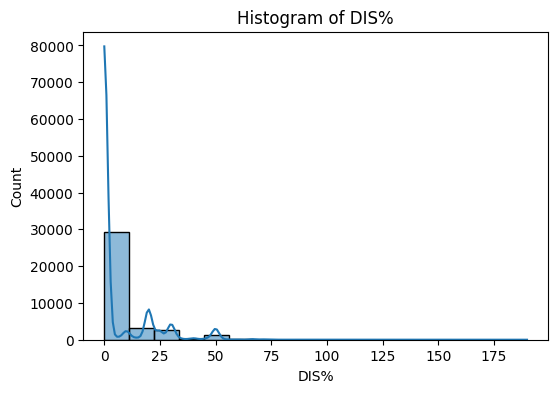

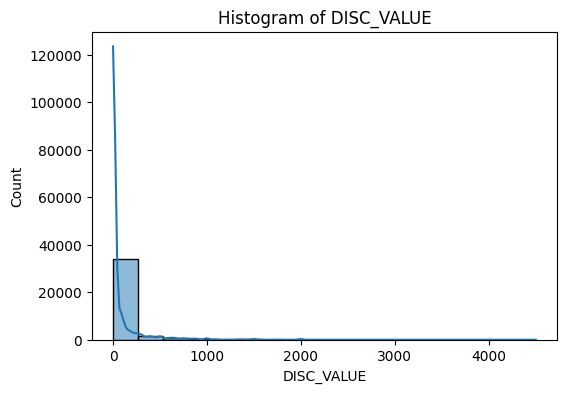

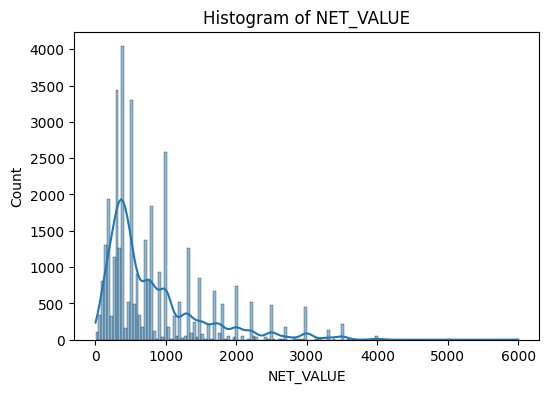

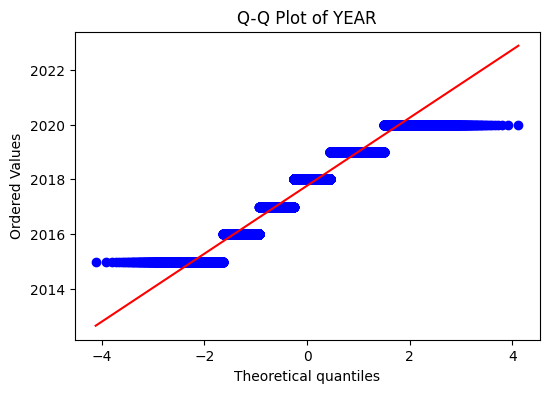

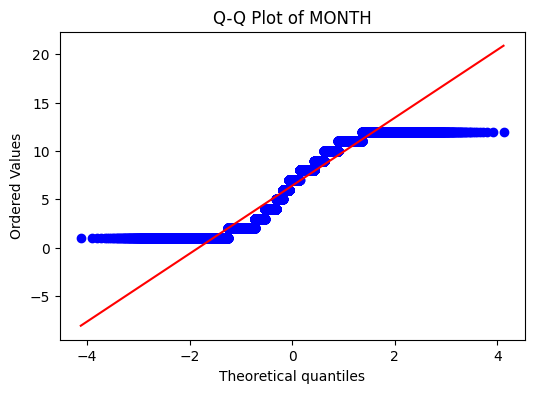

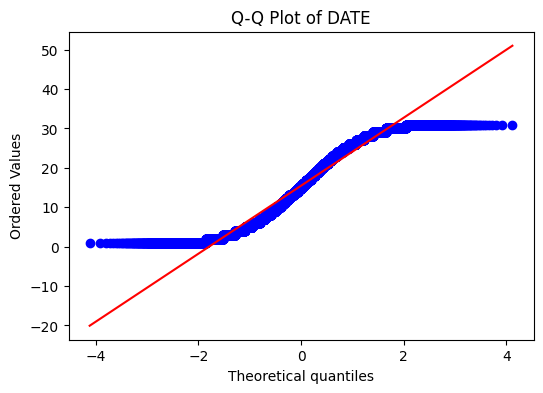

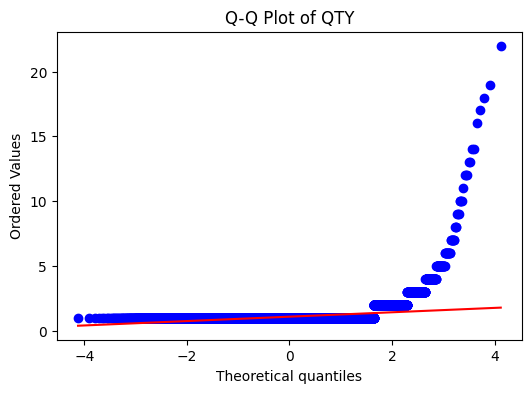

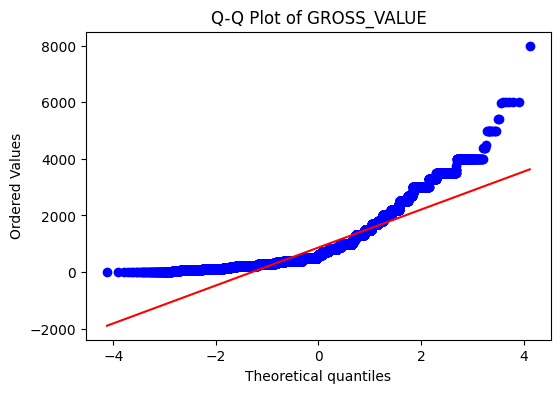

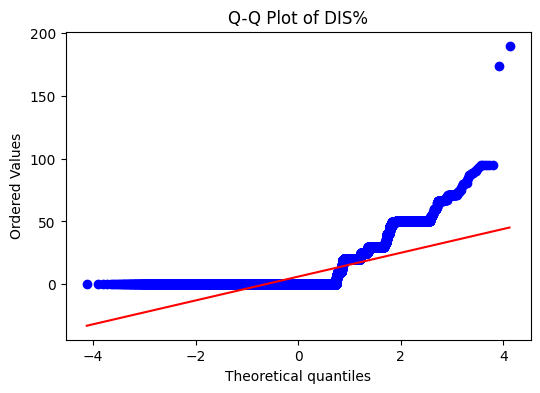

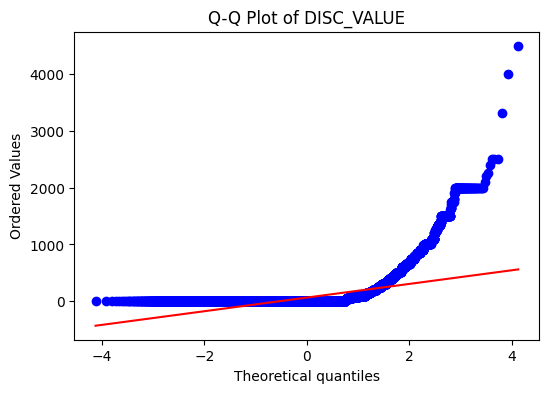

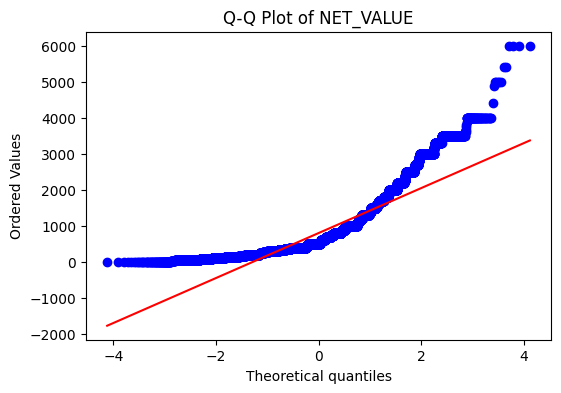

In [93]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

numerical_cols = ["YEAR", "MONTH", "DATE", "QTY", "GROSS_VALUE", "DIS%", "DISC_VALUE", "NET_VALUE"]

#Plot histograms

for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f"Histogram of {col}")
    plt.show()

# Q-Q Plot for checking normality
for col in numerical_cols:
    plt.figure(figsize=(6, 4))
    stats.probplot(data[col], dist="norm", plot=plt)
    plt.title(f"Q-Q Plot of {col}")
    plt.show()

### Because it is not clear from visualization we will do statisticly

In [95]:

from scipy.stats import shapiro

for col in numerical_cols:
    stat, p = shapiro(data[col].dropna())
    print(f"{col}: p-value = {p:.5f}")

    if p > 0.05:
        print("Likely Normally Distributed\n")
    else:
        print("Not Normally Distributed\n")

YEAR: p-value = 0.00000
Not Normally Distributed

MONTH: p-value = 0.00000
Not Normally Distributed

DATE: p-value = 0.00000
Not Normally Distributed

QTY: p-value = 0.00000
Not Normally Distributed

GROSS_VALUE: p-value = 0.00000
Not Normally Distributed

DIS%: p-value = 0.00000
Not Normally Distributed

DISC_VALUE: p-value = 0.00000
Not Normally Distributed

NET_VALUE: p-value = 0.00000
Not Normally Distributed



/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 36668.
  res = hypotest_fun_out(*samples, **kwds)


### We find out that it is not normally distributed hence we can use MinMax Scaling

In [99]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
data.head(20)

,YEAR,MONTH,DATE,ITEM,ARTICLE_NAME,COLOUR,SIZE,BRAND,ITEM_TYPE,LEATHER_TYPE,SEASON,QTY,GROSS_VALUE,DIS%,DISC_VALUE,NET_VALUE
0,0.0,0.636364,0.166667,5873,126,2,24.0,16,0,19,0,0.000000,0.062273,0.0,0.0,0.083014
1,0.0,0.636364,0.166667,6978,162,15,23.0,7,0,9,1,0.000000,0.062273,0.0,0.0,0.083014
2,0.0,0.636364,0.166667,8203,218,33,22.5,4,0,19,0,0.000000,0.074778,0.0,0.0,0.099683
3,0.0,0.636364,0.166667,7386,1196,37,24.0,5,0,19,0,0.000000,0.199825,0.0,0.0,0.266378
4,0.0,0.636364,0.166667,5348,1451,10,26.0,5,0,19,1,0.000000,0.162311,0.0,0.0,0.216369
5,0.0,0.636364,0.166667,4484,1453,33,26.0,5,0,19,1,0.047619,0.199700,0.0,0.0,0.266211
6,0.0,0.636364,0.166667,2878,1533,39,15.0,5,0,19,0,0.000000,0.074778,0.0,0.0,0.099683
7,0.0,0.636364,0.166667,4785,1596,51,26.0,7,0,7,2,0.000000,0.049769,0.0,0.0,0.066344
8,0.0,0.636364,0.200000,7596,73,4,26.5,15,0,15,1,0.000000,0.174816,0.0,0.0,0.233039
9,0.0,0.636364,0.200000,3970,81,6,25.5,16,0,19,1,0.000000,0.112292,0.0,0.0,0.149692


### Starting with Model Training

### ANN using Multi Output Regression

In [107]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Select input features and targets
X = data[['SEASON', 'ITEM_TYPE', 'LEATHER_TYPE', 'SIZE', 'BRAND', 'DIS%']].values
y = data[['QTY', 'GROSS_VALUE', 'NET_VALUE']].values  # Multi-output

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# Define ANN Model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(3, activation='linear')  # 3 outputs
])

# Compile Model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7096 - mae: 0.4729 - val_loss: 0.5151 - val_mae: 0.3984
Epoch 2/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5816 - mae: 0.3808 - val_loss: 0.4628 - val_mae: 0.3531
Epoch 3/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.5273 - mae: 0.3554 - val_loss: 0.4219 - val_mae: 0.3337
Epoch 4/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5182 - mae: 0.3343 - val_loss: 0.3988 - val_mae: 0.3391
Epoch 5/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4894 - mae: 0.3318 - val_loss: 0.3870 - val_mae: 0.3215
Epoch 6/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4348 - mae: 0.3098 - val_loss: 0.3764 - val_mae: 0.3195
Epoch 7/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4430 - mae: 0.3095 - val_loss: 0.3582 - val_mae: 0.3138
Epoch 8/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.4616 - mae: 0.3105 - val_loss: 0.3722 - val_mae: 0.3195
Epoch 9/50
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4331 

In [108]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Predict on test data
y_pred = model.predict(X_test)

# Inverse transform predictions and actual values (if scaled)
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

# Compute RMSE, MAE, and R² Score
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mae = mean_absolute_error(y_test_original, y_pred_original)
r2 = r2_score(y_test_original, y_pred_original)
accuracy = r2 * 100

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"R² Score: {r2}")
print(f"Accuracy: {accuracy:.2f}%")


230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step
RMSE: 0.038372522127785295
MAE: 0.021352966295553985
R² Score: 0.6260605748026129
Accuracy: 62.61%


### Random Forest with Multi Output Regression

Random Forest Results:
MAE: 0.017169678263922006
MSE: 0.0012436779284401907
RMSE: 0.03526581813087839
R² Score: 0.6676784004475497
Accuracy: 66.77%



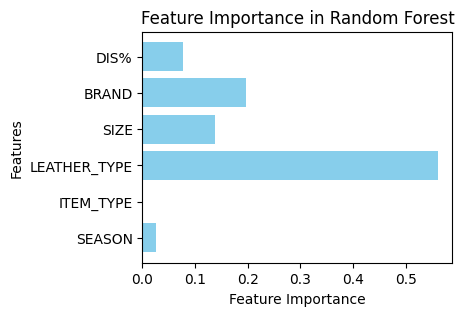

In [110]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Define features and target variables
X = data[['SEASON', 'ITEM_TYPE', 'LEATHER_TYPE', 'SIZE', 'BRAND', 'DIS%']]
y = data[['QTY', 'GROSS_VALUE', 'NET_VALUE']]  # Multi-output regression

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred = rf_model.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
accuracy = r2 * 100  # Convert R² to percentage

print("Random Forest Results:")
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")
print(f"Accuracy: {accuracy:.2f}%\n")  # Print Accuracy as a percentage

# Feature Importance
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(4, 3))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest")
plt.show()


In [116]:
X_train['SIZE'].unique()
X_train['SIZE'] = pd.to_numeric(X_train['SIZE'])
X_test['SIZE'] = pd.to_numeric(X_test['SIZE'])

### XGBoost

In [117]:
import xgboost as xgb
from sklearn.metrics import r2_score

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.05, max_depth=6)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate
r2_xgb = r2_score(y_test, y_pred_xgb)
print("XGBoost R² Score:", r2_xgb)

XGBoost R² Score: 0.6682441830635071


### LightGBM

In [119]:
import lightgbm as lgb
from sklearn.metrics import r2_score

# Create an empty dictionary to store models and results
lgb_models = {}
r2_scores = {}

# Iterate over each target column
for i, target in enumerate(y_train.columns):
    print(f"Training LightGBM for {target}...")

    # Train model for the current target
    lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=6)
    lgb_model.fit(X_train, y_train[target])

    # Store model
    lgb_models[target] = lgb_model

    # Predict and evaluate
    y_pred = lgb_model.predict(X_test)
    r2 = r2_score(y_test[target], y_pred)
    r2_scores[target] = r2

    print(f"{target} R² Score: {r2:.4f}")

# Print overall results
print("Final LightGBM R² Scores:", r2_scores)


Training LightGBM for QTY...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 318
[LightGBM] [Info] Number of data points in the train set: 29334, number of used features: 6
[LightGBM] [Info] Start training from score 0.003529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

### ANN with single output

In [120]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Selecting Features & Target Variable
X = data[['SEASON', 'ITEM_TYPE', 'LEATHER_TYPE', 'SIZE', 'BRAND', 'DIS%']].values
y = data['NET_VALUE'].values  # Single target variable

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Build ANN Model
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='linear')  # Linear Activation for Regression
])

# Compile Model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Train Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Evaluate Model
test_loss, test_mae = model.evaluate(X_test, y_test)
print("Test MAE:", test_mae)

# Predictions
y_pred_ann = model.predict(X_test)

# R² Score
from sklearn.metrics import r2_score
r2_ann = r2_score(y_test, y_pred_ann)
print("ANN R² Score (NET_VALUE):", r2_ann)


Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0070 - mae: 0.0580 - val_loss: 0.0044 - val_mae: 0.0432
Epoch 2/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0045 - mae: 0.0446 - val_loss: 0.0037 - val_mae: 0.0394
Epoch 3/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0036 - mae: 0.0396 - val_loss: 0.0036 - val_mae: 0.0401
Epoch 4/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033 - mae: 0.0377 - val_loss: 0.0029 - val_mae: 0.0344
Epoch 5/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0031 - mae: 0.0365 - val_loss: 0.0029 - val_mae: 0.0338
Epoch 6/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0029 - mae: 0.0351 - val_loss: 0.0031 - val_mae: 0.0385
Epoch 7/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0028 - mae: 0.0343 - val_loss: 0.0028 - val_mae: 0.0356
Epoch 8/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0027 - mae: 0.0340 - val_loss: 0.0027 - val_mae: 0.0339
Epoch 9/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss:

### Random Forest for Single Output

In [144]:
from sklearn.model_selection import train_test_split

X = data[['SEASON', 'ITEM_TYPE', 'LEATHER_TYPE', 'SIZE', 'BRAND', 'DIS%']]
y = data['NET_VALUE']  # Single output

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("Random Forest R² Score (NET_VALUE):", r2)
accuracy = r2 * 100
print(f"Accuracy: {accuracy:.2f}%\n")

Random Forest R² Score (NET_VALUE): 0.8379821072054368
Accuracy: 83.80%



### Checking for Important Features

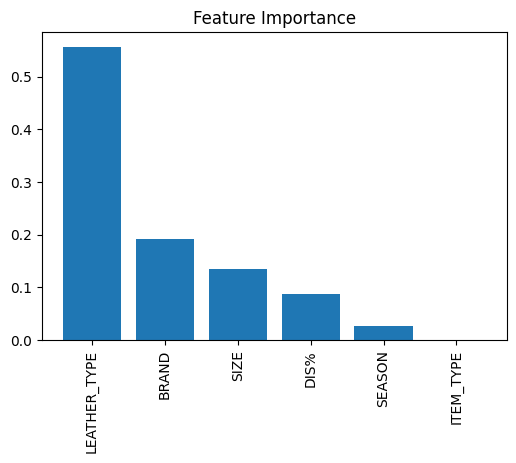

In [131]:

import matplotlib.pyplot as plt
import numpy as np

feature_importance = rf_model.feature_importances_
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(6,4))
plt.bar(range(X.shape[1]), feature_importance[sorted_idx], align="center")
plt.xticks(range(X.shape[1]), X.columns[sorted_idx], rotation=90)
plt.title("Feature Importance")
plt.show()


### Optimizing further using Hyperparameter Tuning

In [134]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

rf_model = RandomForestRegressor(random_state=42)

# Defining the hyperparameter grid
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    rf_model, param_distributions=param_dist, n_iter=20, cv=5,
    scoring='r2', n_jobs=-1, random_state=42
)

random_search.fit(X_train, y_train)

best_rf = random_search.best_estimator_

y_pred_optimized = best_rf.predict(X_test)

r2_optimized = r2_score(y_test, y_pred_optimized)
print("Optimized Random Forest R² Score (NET_VALUE):", r2_optimized)

print("Best Hyperparameters:", random_search.best_params_)
accuracy = r2 * 100
print(f"Accuracy: {accuracy:.2f}%\n")

Optimized Random Forest R² Score (NET_VALUE): 0.8365040280138203
Best Hyperparameters: {'max_depth': 30, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 341}
Accuracy: 83.80%



# **-------------End of Project-------------**

## **-------------Application of the Model-------------**







### **Forecast Demand for the Next Period (Season/Month/Week)**